In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nfl_data_py as nfl

# Define the years to import
yrs = range(2019, 2020)

# Play-by-Play Data
pbp_data = nfl.import_pbp_data(years=[2022])

# Player Stats
player_stats = nfl.import_seasonal_data(years=[2022], s_type='ALL')

# Weekly Rosters
weekly_rosters = nfl.import_weekly_rosters(years=[2022])

# Schedules
schedules = nfl.import_schedules(years=[2022])

# Injuries
injuries = nfl.import_injuries(years=[2022])

# Draft Data
draft_data = nfl.import_draft_picks(years=[2022])

# Combine Data
combine_data = nfl.import_combine_data(years=[2022])

# Weekly Fantasy Data
weekly_fantasy_data = nfl.import_weekly_data(years=[2022])

# Officiating Data
officiating_data = nfl.import_officials(years=[2022])

# Betting Lines
betting_lines = nfl.import_sc_lines([2022])

# Depth Charts
depth_charts = nfl.import_depth_charts(years=[2022])

# Next Gen Stats
next_gen_stats = nfl.import_ngs_data(years=[2022], stat_type='passing')

2022 done.
Downcasting floats.
Downcasting floats.


Attempt to make a dvoa-type metric. Explore how downs impact expected points to make a better epa. 
- Points Above Replacement [PAR]
- First Down Above Replacement [FDAR] how likely are you to obtain another first down on this drive?

Use strength of schedule and matchups to weight player performance. Include situations like 4th quarter.

Can I predict snap count of players? If so, does that help predict points?

Make multiple functions that take in past data (play-by-play) 
- summarize the data by predicting the play outcome (yardage gained, score, 1st down)

Make a function that is able to summarize the effect of each variable on the outcome of the play

So, if each play occurs after the prior; I can make a cumulative sum that tracks the performance of teams
- New features like: Of last 100 plays how many have been touchdowns? How many have been sacks?
- total plays played

Can I feed all columns into a model to predict the future?
- Should I predict the next play? The game result? The next game result? Season win total?
- Can I find the most important features to then summarize for other problems? Can I then reduce the dimensions?
- Or should I just use averages and tendencies to summarize the current data in relation to future data?

Right now there is too much data for each player to put into one dataset to predict the next play
- Feature engineering to organize players based on three or four categories (athletisism, schemes, accolades...)
    - Production (reference for a category to qualify as being good)
        - explosive play rate
        - clutch rating
        - performance after explosive plays
        - consistency rating
        - teammate assistance
        - luck rating (drops, fumble recovery, missed field goals)
    - Tangibles (Athleticism)
        - age, age trends for position
        - height
        - weight
        - speed
        - strength
        - change in weight
        - injuries, return to injury effectiveness
        - total tackles endured
        - performance drop off on short rest times (thursday night games)
    - Schemes (Usage)
        - percent of snaps throwing, catching, running the ball (of specific player and of team)
        - 2-minute drill snap percentage
        - percent of snaps at each position
        - personnel frequencies
        - down/redzone usage
        - aggressiveness rating
        - contact rate (tackle rate)
    - Accolades (Intangibles)
        - salary
        - awards
        - draft stock
        - playoff wins
        - betting lines
        - how many teams have they been on?
- Reduce dimension through cluster analysis (referencing production differences)
- Combine all categories for each player on each play to predict the future

In [4]:
game_info = [
    'play_id', 'game_id', 'old_game_id_x', 'home_team', 'away_team', 'season_type', 'week', 
    'game_date', 'total_home_score', 'total_away_score', 'posteam', 'posteam_type', 'defteam', 
    'location', 'stadium', 'weather', 'temp', 'wind', 'roof', 'surface', 'home_coach', 'away_coach', 
    'stadium_id', 'game_stadium', 'away_score', 'home_score', 'result', 'total', 'spread_line', 
    'total_line', 'div_game', 'home_opening_kickoff', 'nflverse_game_id', 'old_game_id_y'
]

drive_info = [
    'drive', 'drive_real_start_time', 'drive_play_count', 'drive_time_of_possession', 
    'drive_first_downs', 'drive_inside20', 'drive_ended_with_score', 'drive_quarter_start', 
    'drive_quarter_end', 'drive_yards_penalized', 'drive_start_transition', 'drive_end_transition', 
    'drive_game_clock_start', 'drive_game_clock_end', 'drive_start_yard_line', 'drive_end_yard_line', 
    'drive_play_id_started', 'drive_play_id_ended', 'fixed_drive', 'fixed_drive_result'
]

play_info = [
    'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 
    'quarter_end', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 
    'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 
    'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 
    'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 
    'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 
    'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 
    'score_differential', 'posteam_score', 'defteam_score', 'posteam_score_post', 'defteam_score_post', 
    'score_differential_post', 'no_score_prob', 'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob', 
    'fg_prob', 'safety_prob', 'td_prob', 'extra_point_prob', 'two_point_conversion_prob', 'ep', 'epa', 
    'total_home_epa', 'total_away_epa', 'total_home_rush_epa', 'total_away_rush_epa', 
    'total_home_pass_epa', 'total_away_pass_epa', 'air_epa', 'yac_epa', 'comp_air_epa', 'comp_yac_epa', 
    'total_home_comp_air_epa', 'total_away_comp_air_epa', 'total_home_comp_yac_epa', 
    'total_away_comp_yac_epa', 'total_home_raw_air_epa', 'total_away_raw_air_epa', 
    'total_home_raw_yac_epa', 'total_away_raw_yac_epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'wpa', 
    'vegas_wpa', 'vegas_home_wpa', 'home_wp_post', 'away_wp_post', 'vegas_wp', 'vegas_home_wp', 
    'total_home_rush_wpa', 'total_away_rush_wpa', 'total_home_pass_wpa', 'total_away_pass_wpa', 
    'air_wpa', 'yac_wpa', 'comp_air_wpa', 'comp_yac_wpa', 'total_home_comp_air_wpa', 
    'total_away_comp_air_wpa', 'total_home_comp_yac_wpa', 'total_away_comp_yac_wpa', 
    'total_home_raw_air_wpa', 'total_away_raw_air_wpa', 'total_home_raw_yac_wpa', 'total_away_raw_yac_wpa'
]

player_actions = [
    'rush_attempt', 'pass_attempt', 'sack', 'qb_hit', 'qb_hit_1_player_id', 'qb_hit_1_player_name', 
    'qb_hit_2_player_id', 'qb_hit_2_player_name', 'solo_tackle', 'assist_tackle', 'tackled_for_loss', 
    'tackle_for_loss_1_player_id', 'tackle_for_loss_1_player_name', 'tackle_for_loss_2_player_id', 
    'tackle_for_loss_2_player_name', 'forced_fumble_player_1_team', 'forced_fumble_player_1_player_id', 
    'forced_fumble_player_1_player_name', 'forced_fumble_player_2_team', 'forced_fumble_player_2_player_id', 
    'forced_fumble_player_2_player_name', 'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 
    'fumble_lost', 'fumble_recovery_1_team', 'fumble_recovery_1_yards', 'fumble_recovery_1_player_id', 
    'fumble_recovery_1_player_name', 'fumble_recovery_2_team', 'fumble_recovery_2_yards', 
    'fumble_recovery_2_player_id', 'fumble_recovery_2_player_name', 'interception', 'interception_player_id', 
    'interception_player_name', 'lateral_interception_player_id', 'lateral_interception_player_name', 
    'pass_defense_1_player_id', 'pass_defense_1_player_name', 'pass_defense_2_player_id', 
    'pass_defense_2_player_name', 'punt_blocked', 'punt_inside_twenty', 'punt_in_endzone', 
    'punt_out_of_bounds', 'punt_downed', 'punt_fair_catch', 'kickoff_inside_twenty', 'kickoff_in_endzone', 
    'kickoff_out_of_bounds', 'kickoff_downed', 'kickoff_fair_catch', 'own_kickoff_recovery', 
    'own_kickoff_recovery_td', 'own_kickoff_recovery_player_id', 'own_kickoff_recovery_player_name', 
    'blocked_player_id', 'blocked_player_name', 'punt_returner_player_id', 'punt_returner_player_name', 
    'kickoff_returner_player_id', 'kickoff_returner_player_name', 'punter_player_id', 'punter_player_name', 
    'kicker_player_id', 'kicker_player_name', 'passer_player_id', 'passer_player_name', 'passing_yards', 
    'receiver_player_id', 'receiver_player_name', 'receiving_yards', 'rusher_player_id', 'rusher_player_name', 
    'rushing_yards', 'lateral_receiver_player_id', 'lateral_receiver_player_name', 'lateral_receiving_yards', 
    'lateral_rusher_player_id', 'lateral_rusher_player_name', 'lateral_rushing_yards', 'lateral_sack_player_id', 
    'lateral_sack_player_name', 'assist_tackle_1_player_id', 'assist_tackle_1_player_name', 
    'assist_tackle_1_team', 'assist_tackle_2_player_id', 'assist_tackle_2_player_name', 
    'assist_tackle_2_team', 'assist_tackle_3_player_id', 'assist_tackle_3_player_name', 
    'assist_tackle_3_team', 'assist_tackle_4_player_id', 'assist_tackle_4_player_name', 
    'assist_tackle_4_team', 'solo_tackle_1_team', 'solo_tackle_2_team', 'solo_tackle_1_player_id', 
    'solo_tackle_2_player_id', 'solo_tackle_1_player_name', 'solo_tackle_2_player_name', 'fumbled_1_team', 
    'fumbled_1_player_id', 'fumbled_1_player_name', 'fumbled_2_player_id', 'fumbled_2_player_name', 
    'fumbled_2_team', 'return_team', 'return_yards', 'penalty_team', 'penalty_player_id', 
    'penalty_player_name', 'penalty_yards', 'penalty', 'penalty_type', 'replay_or_challenge', 
    'replay_or_challenge_result', 'defensive_two_point_attempt', 'defensive_two_point_conv', 
    'defensive_extra_point_attempt', 'defensive_extra_point_conv', 'first_down_rush', 'first_down_pass', 
    'first_down_penalty', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
    'fourth_down_failed', 'incomplete_pass', 'touchback', 'safety', 'tackled_for_loss', 'fumble', 
    'complete_pass', 'lateral_reception', 'lateral_rush', 'lateral_return', 'lateral_recovery', 
    'touchdown', 'pass_touchdown', 'rush_touchdown', 'return_touchdown', 'extra_point_attempt', 
    'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt', 'punt_attempt'
]

special_teams = [
    'special_teams_play', 'st_play_type', 'punt_blocked', 'punt_inside_twenty', 'punt_in_endzone', 
    'punt_out_of_bounds', 'punt_downed', 'punt_fair_catch', 'kickoff_inside_twenty', 'kickoff_in_endzone', 
    'kickoff_out_of_bounds', 'kickoff_downed', 'kickoff_fair_catch', 'own_kickoff_recovery', 
    'own_kickoff_recovery_td', 'punt_returner_player_id', 'punt_returner_player_name', 
    'kickoff_returner_player_id', 'kickoff_returner_player_name', 'punter_player_id', 'punter_player_name', 
    'kicker_player_id', 'kicker_player_name', 'blocked_player_id', 'blocked_player_name'
]

clock_and_time = [
    'start_time', 'time_of_day', 'play_clock', 'end_clock_time', 'drive_game_clock_start', 
    'drive_game_clock_end'
]

advanced_metrics = [
    'cp', 'cpoe', 'series', 'series_success', 'series_result', 'order_sequence', 'nfl_api_id', 
    'play_deleted', 'play_type_nfl', 'aborted_play', 'success', 'passer', 'passer_jersey_number', 
    'rusher', 'rusher_jersey_number', 'receiver', 'receiver_jersey_number', 'pass', 'rush', 'first_down', 
    'special', 'play', 'passer_id', 'rusher_id', 'receiver_id', 'name', 'jersey_number', 'id', 
    'fantasy_player_name', 'fantasy_player_id', 'fantasy', 'fantasy_id', 'out_of_bounds', 'qb_epa', 
    'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 'xyac_success', 'xyac_fd', 'xpass', 
    'pass_oe', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 
    'defense_personnel', 'number_of_pass_rushers', 'players_on_play', 'offense_players', 'defense_players', 
    'n_offense', 'n_defense', 'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route', 
    'defense_man_zone_type', 'defense_coverage_type'
]

In [5]:
# load depth chart data
depth_charts[['season', 'club_code', 'week', 'depth_team', 'gsis_id', 'position', 'full_name']].head(10)

,season,club_code,week,depth_team,gsis_id,position,full_name
0,2022,ATL,1.0,2,00-0036956,CB,Darren Hall
1,2022,ATL,1.0,3,00-0037034,CB,Dee Alford
2,2022,ATL,1.0,1,00-0029261,CB,Casey Hayward
3,2022,ATL,1.0,3,00-0036825,TE,Feleipe Franks
4,2022,ATL,1.0,1,00-0036970,TE,Kyle Pitts
5,2022,ATL,1.0,1,00-0033676,G,Elijah Wilkinson
6,2022,ATL,1.0,1,00-0035630,G,Chris Lindstrom
7,2022,ATL,1.0,1,00-0035572,TE,Parker Hesse
8,2022,ATL,1.0,2,00-0030874,RB,Damien Williams
9,2022,ATL,1.0,3,00-0037263,RB,Tyler Allgeier


In [6]:
# pbp data
pbp_data[['game_id', 'week', 'posteam', 'play_id', 'play_type', 'offense_players']].sort_values(['game_id', 'play_id']).head()

,game_id,week,posteam,play_id,play_type,offense_players
0,2022_01_BAL_NYJ,1,None,1.0,None,
1,2022_01_BAL_NYJ,1,NYJ,43.0,kickoff,00-0036157;00-0035202;00-0037984;00-0029597;00...
2,2022_01_BAL_NYJ,1,NYJ,68.0,run,00-0036924;00-0032466;00-0036979;00-0032234;00...
3,2022_01_BAL_NYJ,1,NYJ,89.0,pass,00-0036924;00-0032466;00-0032234;00-0036979;00...
4,2022_01_BAL_NYJ,1,NYJ,115.0,run,00-0036924;00-0032466;00-0036979;00-0032234;00...


## Split offensive players into columns

In [7]:
# Split the offense_players column into multiple columns for each player
offensive_players = pbp_data['offense_players'].str.split(';', expand=True)

# Ensure there are always 11 columns by filling missing values with None
offensive_players = offensive_players.reindex(columns=range(11), fill_value=None)

# Rename the columns
offensive_players.columns = [
    'offensive_player_1', 'offensive_player_2', 'offensive_player_3', 'offensive_player_4', 
    'offensive_player_5', 'offensive_player_6', 'offensive_player_7', 'offensive_player_8', 
    'offensive_player_9', 'offensive_player_10', 'offensive_player_11'
]

# Concatenate the original pbp_data with the new offense_players columns
pbp = pd.concat([pbp_data[['game_id', 'week', 'posteam', 'play_id', 'play_type']], offensive_players], axis=1)

# Filter rows where play_type is not 'None'
pbp = pbp[pbp['play_type'].notna()]

pbp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47985 entries, 1 to 49432
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   game_id              47985 non-null  object 
 1   week                 47985 non-null  int32  
 2   posteam              45851 non-null  object 
 3   play_id              47985 non-null  float32
 4   play_type            47985 non-null  object 
 5   offensive_player_1   47985 non-null  object 
 6   offensive_player_2   45851 non-null  object 
 7   offensive_player_3   45851 non-null  object 
 8   offensive_player_4   45851 non-null  object 
 9   offensive_player_5   45851 non-null  object 
 10  offensive_player_6   45851 non-null  object 
 11  offensive_player_7   45851 non-null  object 
 12  offensive_player_8   45851 non-null  object 
 13  offensive_player_9   45851 non-null  object 
 14  offensive_player_10  45851 non-null  object 
 15  offensive_player_11  45845 non-null 

# Create Useful columns

In [12]:
# Change 'fixed_drive_result' from text to points
pbp_data['fixed_drive_result'] = pbp_data['fixed_drive_result'].replace({
    'Touchdown': 6,
    'Field Goal': 3,
    'Safety': -2,
    'End of Half': 0,
    'End of Game': 0,
    'Missed FG': 0,
    'No Play': 0,
    'Turnover on Downs': 0,
    'Fumble': 0,
    'Interception': 0,
    'Punt': 0
})

## Transform to long format

In [10]:
# Transform pbp to long format with offense_player columns as rows
pbp_long = pd.melt(pbp, id_vars=['game_id', 'week', 'posteam', 'play_id'], 
                   value_vars=offensive_players.columns, var_name='off_player_number', value_name='player_id')
pbp_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527835 entries, 0 to 527834
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   game_id            527835 non-null  object 
 1   week               527835 non-null  int32  
 2   posteam            504361 non-null  object 
 3   play_id            527835 non-null  float32
 4   off_player_number  527835 non-null  object 
 5   player_id          506489 non-null  object 
dtypes: float32(1), int32(1), object(4)
memory usage: 20.1+ MB


## Discover the best length of recency bias to predict the future (10, 100, 1000 snaps)

In [27]:
# Transform pbp to long format with offense_player columns as rows
pbp_long = pd.melt(pbp, id_vars=['game_id', 'posteam', 'play_id'], 
                   value_vars=offensive_players.columns, var_name='off_player_number', value_name='player_id')

# Columns necessary for merge
merge_cols = ['game_id', 'posteam', 'play_id']

# Useful/important columns to merge from pbp_data
useful_cols = [
    'play_type', # type of play (pass, rush, etc.
    'ydstogo', # yards to go for the next first down
    #'ydsnet', # net yards gained on the play (yards gained - penalty yards) and includes kickoff
    'yards_gained', # yards gained on the play
    'fixed_drive_result', # result of the drive (e.g., touchdown, field goal, etc.)
    'epa', # expected points added on the play
    'wpa', # win probability added on the play
]

# Merge 'ydstogo', 'ydsnet', 'yards_gained' from pbp_data to pbp_long
pbp_long = pbp_long.merge(pbp_data[merge_cols + useful_cols],
                            on=merge_cols, how='left')

pbp_long.head(10)

,game_id,posteam,play_id,off_player_number,player_id,play_type,ydstogo,yards_gained,fixed_drive_result,epa,wpa
0,2022_01_BAL_NYJ,NYJ,43.0,offensive_player_1,00-0036157,kickoff,0.0,0.0,0,-0.443521,0.000707
1,2022_01_BAL_NYJ,NYJ,68.0,offensive_player_1,00-0036924,run,10.0,19.0,0,1.468819,0.025604
2,2022_01_BAL_NYJ,NYJ,89.0,offensive_player_1,00-0036924,pass,10.0,0.0,0,-0.492192,-0.018037
3,2022_01_BAL_NYJ,NYJ,115.0,offensive_player_1,00-0036924,run,10.0,5.0,0,-0.325931,-0.014369
4,2022_01_BAL_NYJ,NYJ,136.0,offensive_player_1,00-0036924,pass,5.0,0.0,0,-2.402200,-0.052114
5,2022_01_BAL_NYJ,NYJ,172.0,offensive_player_1,00-0032134,punt,15.0,0.0,0,-0.231632,0.016127
6,2022_01_BAL_NYJ,BAL,202.0,offensive_player_1,00-0033118,pass,10.0,4.0,0,0.075127,0.000774
7,2022_01_BAL_NYJ,BAL,230.0,offensive_player_1,00-0033118,pass,6.0,4.0,0,-0.105120,0.002137
8,2022_01_BAL_NYJ,BAL,254.0,offensive_player_1,00-0034978,run,2.0,4.0,0,0.895055,0.023703
9,2022_01_BAL_NYJ,BAL,275.0,offensive_player_1,00-0033118,run,10.0,0.0,0,-0.529274,-0.015664


C:\Users\Jack\AppData\Local\Temp\ipykernel_40936\457845730.py:20: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pbp_long['running_avg_player_epa'] = pbp_long.groupby('player_id')['epa'].apply(lambda x: x.shift(1).rolling(a, min_periods=a).mean())
C:\Users\Jack\AppData\Local\Temp\ipykernel_40936\457845730.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil

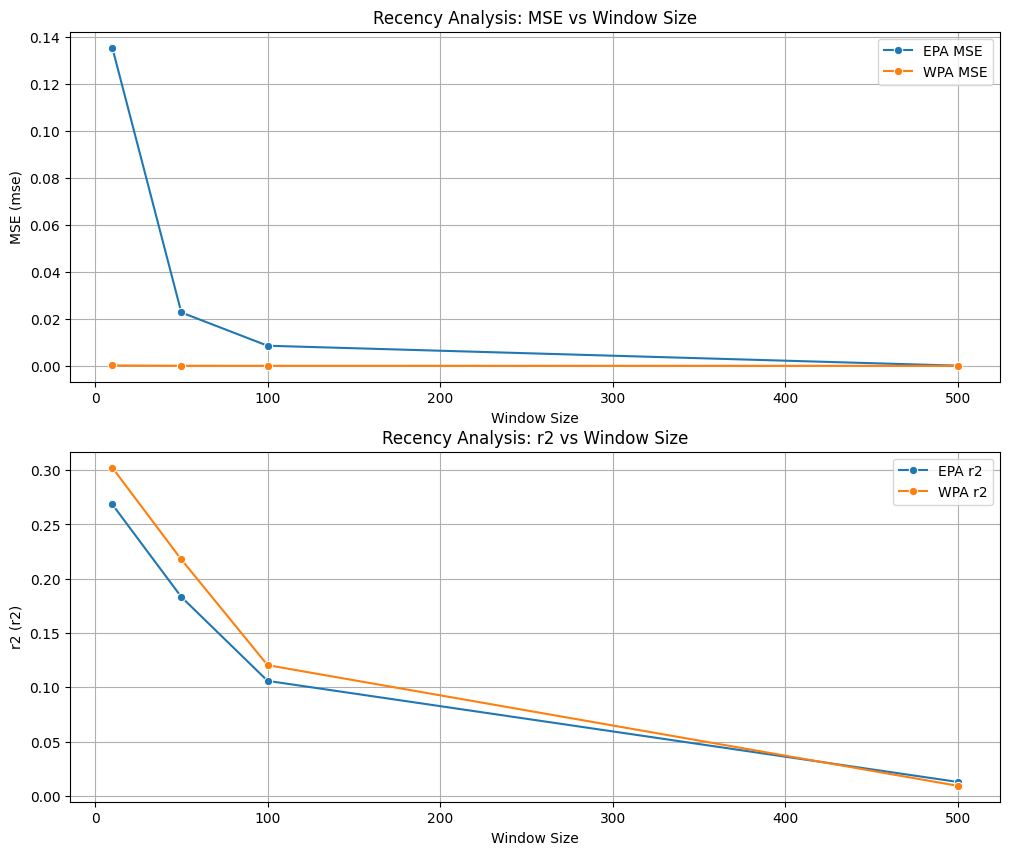

In [28]:
import pandas as pd
import nfl_data_py as nfl
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Define the recency_analysis function
def recency_analysis(pbp_long, a=10):

    # Cumulative stats
    pbp_long['cumulative_player_snaps'] = pbp_long.groupby('player_id').cumcount() + 1
    pbp_long['cumulative_player_epa'] = pbp_long.groupby('player_id')['epa'].cumsum()
    pbp_long['cumulative_player_wpa'] = pbp_long.groupby('player_id')['wpa'].cumsum()
    pbp_long['cumulative_player_yards'] = pbp_long.groupby('player_id')['yards_gained'].cumsum()

    # Rolling averages without data leakage
    pbp_long['running_avg_player_epa'] = pbp_long.groupby('player_id')['epa'].apply(lambda x: x.shift(1).rolling(a, min_periods=a).mean())
    pbp_long['running_avg_player_wpa'] = pbp_long.groupby('player_id')['wpa'].apply(lambda x: x.shift(1).rolling(a, min_periods=a).mean())
    pbp_long['running_avg_player_yards'] = pbp_long.groupby('player_id')['yards_gained'].apply(lambda x: x.shift(1).rolling(a, min_periods=a).mean())

    # Delta features
    pbp_long['delta_avg_player_epa'] = pbp_long['running_avg_player_epa'].diff()
    pbp_long['delta_avg_player_wpa'] = pbp_long['running_avg_player_wpa'].diff()

    # Drop NaN values created by rolling
    pbp_long.dropna(subset=['delta_avg_player_epa', 'delta_avg_player_wpa'], inplace=True)

    # Initialize the model
    model = Ridge(alpha=1.0)
    scaler = StandardScaler()
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    results = []

    dependent_vars = ['delta_avg_player_epa', 'delta_avg_player_wpa']
    independent_vars = ['running_avg_player_epa', 'running_avg_player_wpa', 'cumulative_player_snaps']

    for dep_var in dependent_vars:
        for train_index, test_index in kf.split(pbp_long):
            # Split the data into training and testing sets
            X_train, X_test = pbp_long[independent_vars].iloc[train_index], pbp_long[independent_vars].iloc[test_index]
            y_train, y_test = pbp_long[dep_var].iloc[train_index], pbp_long[dep_var].iloc[test_index]

            # Scale the features
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Fit the model
            model.fit(X_train_scaled, y_train)

            # Make predictions
            y_pred = model.predict(X_test_scaled)

            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            results.append({'dep_var': dep_var, 'mse': mse, 'r2': r2, 'window_size': a})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Run the recency analysis with different window sizes
recency_results_a = recency_analysis(pbp_long, a=10)
recency_results_b = recency_analysis(pbp_long, a=50)
recency_results_c = recency_analysis(pbp_long, a=100)
recency_results_d = recency_analysis(pbp_long, a=500)

# Add window size to each results DataFrame
recency_results_a['window_size'] = 10
recency_results_b['window_size'] = 50
recency_results_c['window_size'] = 100
recency_results_d['window_size'] = 500

# Concatenate the results
recency_results = pd.concat([recency_results_a, recency_results_b, recency_results_c, recency_results_d])

# Pivot the results DataFrame using pivot_table to handle duplicates
recency_results_pivot = recency_results.pivot_table(index='window_size', columns='dep_var', values=['mse', 'r2'], aggfunc='mean').reset_index()

# Plot the results
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
sns.lineplot(data=recency_results_pivot, x='window_size', y=('mse', 'delta_avg_player_epa'), label='EPA MSE', marker='o')
sns.lineplot(data=recency_results_pivot, x='window_size', y=('mse', 'delta_avg_player_wpa'), label='WPA MSE', marker='o')
plt.title('Recency Analysis: MSE vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('MSE (mse)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
sns.lineplot(data=recency_results_pivot, x='window_size', y=('r2', 'delta_avg_player_epa'), label='EPA r2', marker='o')
sns.lineplot(data=recency_results_pivot, x='window_size', y=('r2', 'delta_avg_player_wpa'), label='WPA r2', marker='o')
plt.title('Recency Analysis: r2 vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('r2 (r2)')
plt.legend()
plt.grid(True)
plt.show()

# Feature Engineering

In [ ]:
# Production (reference for a category to qualify as being good)
    # explosive play rate
    # clutch rating
    # performance after explosive plays
    # consistency rating
    # teammate assistance
    # luck rating (drops, fumble recovery, missed field goals)